In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
import lightgbm as lgb
import hyperopt
import random
import time
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('C:/Users/DFursov/Documents/WORK_FILTER_FOR_ABTR_30NOV18.csv', sep = ';', nrows = 700000, encoding = 'cp1251')

In [3]:
# Определение технических функций для очистки таблиц

def DelTargetColumns(df, target):
    cols = []
    for i in df.columns:
        if i.find('tar_') != -1:
            cols.append(i)
    if target in df.columns:
        cols.remove(target)
    else:
        raise NameError('''This column don't exist in pd.DataFrame''')
    df = df.drop(cols, axis = 1)
    return df

def DelObjectColumns(df):
    cols = []
    for i in df.columns:
        if df[i].dtype == 'O':
            cols.append(i)
    df = df.drop(cols, axis = 1)
    return df

In [4]:
target = 'tar_hairmask_14d'
df = DelTargetColumns(df, target)
df = DelObjectColumns(df)

In [5]:
train_columns = list(df.columns)
train_columns.remove('itm_amo_sum_12m_soap')
train_columns.remove('itm_amo_sum_6m_soap')
train_columns.remove('itm_amo_sum_3m_soap')
train_columns.remove('itm_amo_sum_1m_soap')
train_columns.remove('itm_cnt_sum_12m_soap')
train_columns.remove('itm_cnt_sum_6m_soap')
train_columns.remove('itm_cnt_sum_3m_soap')
train_columns.remove('itm_cnt_sum_1m_soap')
train_columns.remove('itm_ind_12m_soap')
train_columns.remove('itm_ind_6m_soap')
train_columns.remove('itm_ind_3m_soap')
train_columns.remove('itm_ind_1m_soap')
train_columns.remove('itm_days_soap')
train_columns.remove(target)

y = df[target]
X = df[train_columns]
del df

# Откладываем 20% данных для тестовой выборки. Валидируемся кросс-валидацией на 5 фолдов на train-наборе
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [6]:
# Убираем выбросы из данных и заменяем пропущенные значения медианами

del X
del y
smp = SimpleImputer(strategy = 'median')
x_train = smp.fit_transform(x_train)
x_test = smp.transform(x_test)
iso_forest = IsolationForest(random_state = 42, bootstrap = True)
outliers = iso_forest.fit_predict(x_train, y_train)
x_train = pd.DataFrame(data = x_train, columns = train_columns)
x_train['outliers'] = outliers
x_train = x_train[x_train['outliers'] == 1]
x_train = x_train.drop('outliers', axis = 1)
y_train = y_train[outliers == 1]
x_train.replace(-np.inf, 0, inplace = True)
x_train.replace(np.inf, 0, inplace = True)

C:\Users\DFursov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\Users\DFursov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\DFursov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


### Неоткалиброванный классификатор + hyperopt

In [7]:
# Пространство перебора гиперпараметров для hyperopt

space ={
        'boosting_type': hp.choice( 'boosting_type', ['gbdt', 'dart' ] ),
        'max_depth': scope.int(hp.quniform("max_depth", 4, 10, 1)),
        'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 10)),
        'num_leaves': scope.int(hp.quniform ('num_leaves', 20, 100, 1)),
        'min_data_in_leaf':  scope.int(hp.quniform ('min_data_in_leaf', 10, 100, 1)),
        'feature_fraction': hp.uniform('feature_fraction', 0.6, 1.0),
        'bagging_fraction': hp.uniform('bagging_fraction', 0.6, 1.0),
        'learning_rate': hp.uniform('learning_rate', 0.001, 0.4),
        'lambda_l1': hp.uniform('lambda_l1', 1e-6, 5 ),
        'lambda_l2': hp.uniform('lambda_l2', 1e-6, 5 ),
        'seed': hp.randint('seed',2000000)
       }

In [8]:
# Целевая функция для hyperopt (по ней оптимизируемся)

def objective(space):
    clf = lgb.LGBMClassifier(**space)
    current_score = cross_val_score(clf, x_train, y_train, cv = 5, scoring = make_scorer(roc_auc_score, needs_proba = True)).mean()
    return -current_score

In [9]:
# Оптимизация hyperopt

best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 30)

100%|█████████████████████████████████████████████| 30/30 [11:02:37<00:00, 1236.72s/it, best loss: -0.7693743237816314]


In [10]:
best # наилучшие гиперпараметры

{'bagging_fraction': 0.600248312307422,
 'boosting_type': 0,
 'feature_fraction': 0.7918931369413271,
 'lambda_l1': 3.7810142882434405,
 'lambda_l2': 3.087231869961073,
 'learning_rate': 0.00691252861975232,
 'max_depth': 5.0,
 'min_data_in_leaf': 30.0,
 'n_estimators': 670.0,
 'num_leaves': 82.0,
 'seed': 286741}

In [13]:
# определеяем модель с подобранными гиперпараметрами
lgb_model = lgb.LGBMClassifier(bagging_fraction = 0.600248312307422,
 boosting_type = 'gbdt',
 feature_fraction = 0.7918931369413271,
 lambda_l1 = 3.7810142882434405,
 lambda_l2 = 3.087231869961073,
 learning_rate = 0.00691252861975232,
 max_depth = 5,
 min_data_in_leaf = 30,
 n_estimators = 670,
 num_leaves = 82,
 seed = 286741)

In [14]:
lgb_model.fit(x_train, y_train)

LGBMClassifier(bagging_fraction=0.600248312307422, boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.7918931369413271, importance_type='split',
        lambda_l1=3.7810142882434405, lambda_l2=3.087231869961073,
        learning_rate=0.00691252861975232, max_depth=5,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
        min_split_gain=0.0, n_estimators=670, n_jobs=-1, num_leaves=82,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        seed=286741, silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

In [15]:
# предсказания для трейна/теста
lgb_predict_train = lgb_model.predict_proba(x_train)[:,1]
lgb_predict_test = lgb_model.predict_proba(x_test)[:,1]

In [17]:
lgb_pred = pd.Series(lgb_predict_test)
lgb_pred = lgb_pred.apply(lambda x: 1 if x >= 0.06 else 0)

In [18]:
print(accuracy_score(y_test, lgb_pred))
print(recall_score(y_test, lgb_pred))
print(precision_score(y_test, lgb_pred))

0.9715214285714285
0.20866666666666667
0.1005460970125281


In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, lgb_pred)

array([[135700,   2800],
       [  1187,    313]], dtype=int64)

In [20]:
rc = list()
prob = 0
while prob < 1:
    prob += 0.01
    lgb_pred = pd.Series(lgb_predict_test)
    lgb_pred = lgb_pred.apply(lambda x: 1 if x >= prob else 0)
    rc.append(recall_score(y_test, lgb_pred))

In [21]:
prec = list()
prob = 0
while prob < 1:
    prob += 0.01
    lgb_pred = pd.Series(lgb_predict_test)
    lgb_pred = lgb_pred.apply(lambda x: 1 if x >= prob else 0)
    prec.append(precision_score(y_test, lgb_pred))

C:\Users\DFursov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


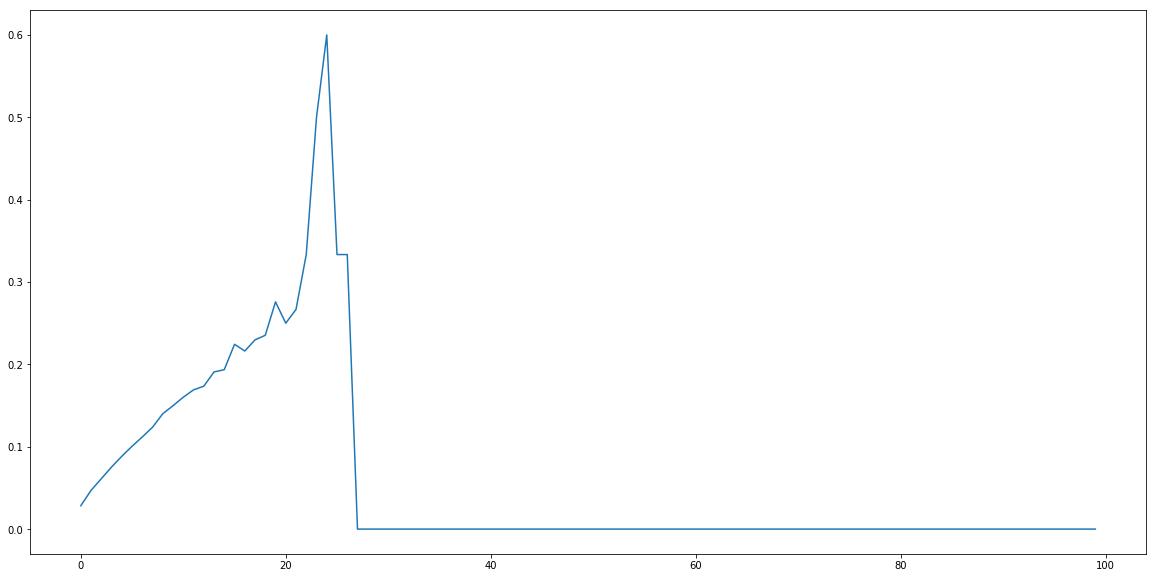

In [22]:
plt.figure(figsize = (20, 10))
plt.plot(prec)

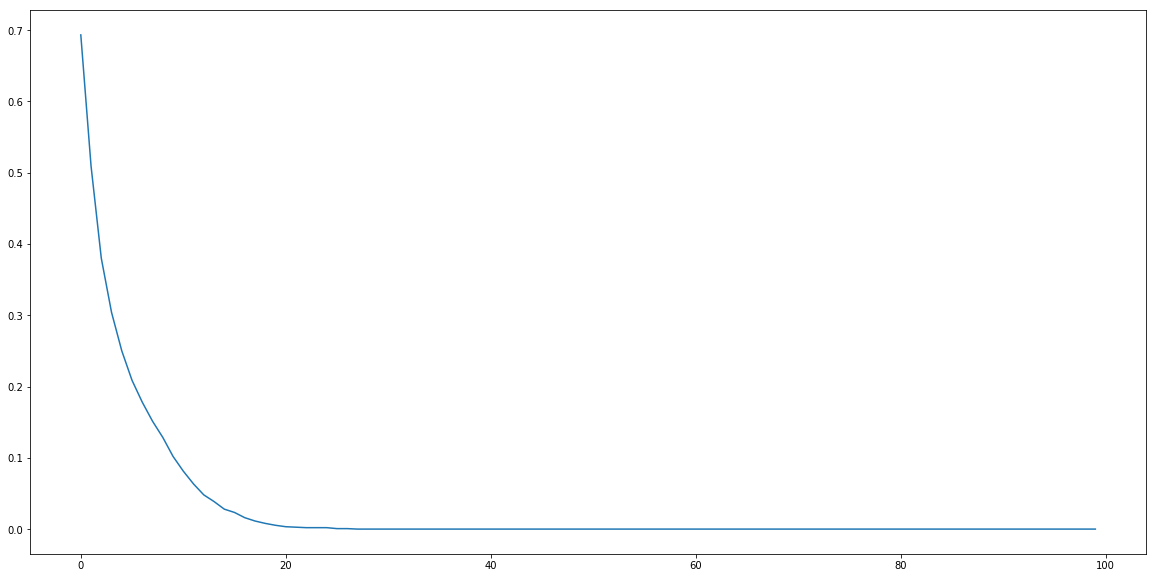

In [23]:
plt.figure(figsize = (20, 10))
plt.plot(rc)

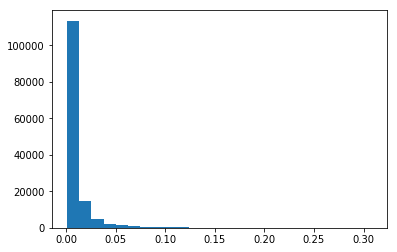

In [24]:
import matplotlib.pyplot as plt
plt.hist(lgb_predict_test, bins = 25)
plt.show()

In [25]:
from sklearn.metrics import f1_score

In [26]:
lgb_pred = pd.Series(lgb_predict_test)
lgb_pred = lgb_pred.apply(lambda x: 1 if x >= 0.5 else 0)

In [27]:
print(f1_score(y_test, lgb_pred))

C:\Users\DFursov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0


In [28]:
print(roc_auc_score(y_train, lgb_predict_train))
print(roc_auc_score(y_test, lgb_predict_test))

0.8260878707069115
0.7893414440433214


In [29]:
from sklearn.externals import joblib
joblib.dump(lgb_model, 'lgb_tar_hairmask_14d_clear.pkl')

['lgb_tar_hairmask_14d_clear.pkl']

In [30]:
bst = joblib.load('lgb_tar_14d.pkl')

In [31]:
imp = pd.Series(lgb_model.feature_importances_, index = train_columns)

In [32]:
from sklearn.calibration import calibration_curve

In [33]:
fop, mpv = calibration_curve(y_test, lgb_predict_test, n_bins = 10)

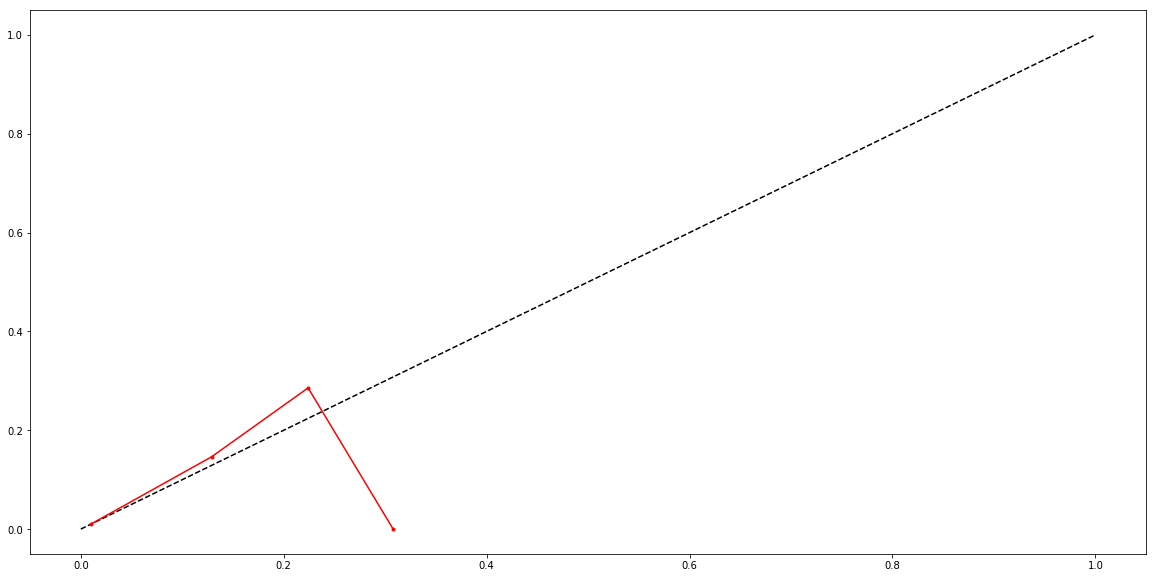

In [34]:
plt.figure(figsize = (20, 10))
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'black')
plt.plot(mpv, fop, marker = '.', color = 'red')

### Откалиброванный классификатор

In [35]:
from sklearn.calibration import CalibratedClassifierCV
lgb_model2 = lgb.LGBMClassifier(bagging_fraction = 0.600248312307422,
 boosting_type = 'gbdt',
 feature_fraction = 0.7918931369413271,
 lambda_l1 = 3.7810142882434405,
 lambda_l2 = 3.087231869961073,
 learning_rate = 0.00691252861975232,
 max_depth = 5,
 min_data_in_leaf = 30,
 n_estimators = 670,
 num_leaves = 82,
 seed = 286741)

lgb_calibrated = CalibratedClassifierCV(base_estimator = lgb_model2, method = 'isotonic', cv = 5)

In [36]:
lgb_calibrated.fit(x_train, y_train)

CalibratedClassifierCV(base_estimator=LGBMClassifier(bagging_fraction=0.600248312307422, boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.7918931369413271, importance_type='split',
        lambda_l1=3.7810142882434405, lambda_l2=3.087231869961073,
        learning_rate=0.00...        seed=286741, silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0),
            cv=5, method='isotonic')

In [37]:
pred_calibrated = lgb_calibrated.predict_proba(x_test)[:, 1]

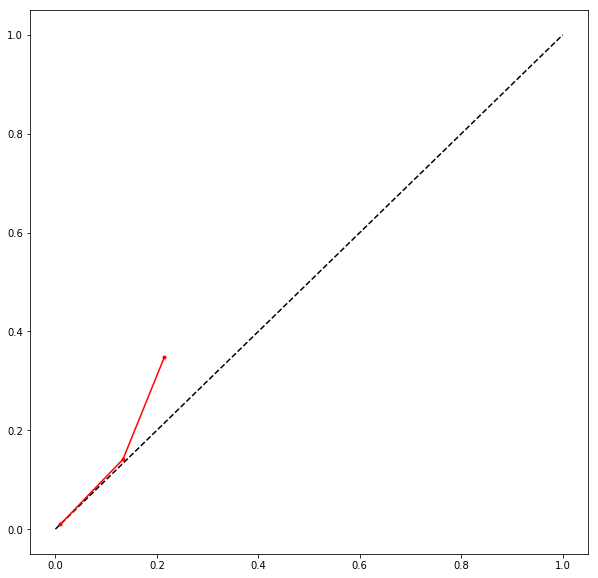

In [38]:
fop_calibrated, mpv_calibrated = calibration_curve(y_test, pred_calibrated, n_bins = 10)
plt.figure(figsize = (10, 10))
plt.plot([0,1], [0,1], linestyle = '--', color = 'black')
plt.plot(mpv_calibrated, fop_calibrated, marker = '.', color = 'red')

In [39]:
joblib.dump(lgb_calibrated, 'lgb_calibrated_tar_hairmask_14d.pkl')

['lgb_calibrated_tar_hairmask_14d.pkl']

In [40]:
print(roc_auc_score(y_test, pred_calibrated))

0.7901178580024067


In [42]:
lgb_pred2 = pd.Series(pred_calibrated)
lgb_pred2 = lgb_pred2.apply(lambda x: 1 if x >= 0.06 else 0)
print(accuracy_score(y_test, lgb_pred2))
print(recall_score(y_test, lgb_pred2))
print(precision_score(y_test, lgb_pred2))

0.9704571428571429
0.21466666666666667
0.09817073170731708


In [43]:
confusion_matrix(y_test, lgb_pred2)

array([[135542,   2958],
       [  1178,    322]], dtype=int64)

In [44]:
pred_calibrated.max()

0.23955098110027687

(array([9.3529e+04, 2.4006e+04, 8.0730e+03, 4.1920e+03, 2.4560e+03,
        1.8850e+03, 1.0030e+03, 7.2800e+02, 5.4300e+02, 5.5700e+02,
        4.3000e+02, 1.8400e+02, 1.6200e+02, 1.3400e+02, 1.0600e+02,
        9.3000e+01, 7.1000e+01, 7.6000e+01, 7.3000e+01, 6.6000e+01,
        5.8000e+01, 1.9000e+01, 2.6000e+01, 4.0000e+00, 1.1000e+01,
        7.0000e+00, 1.0000e+00, 4.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([0.        , 0.00798503, 0.01597007, 0.0239551 , 0.03194013,
        0.03992516, 0.0479102 , 0.05589523, 0.06388026, 0.07186529,
        0.07985033, 0.08783536, 0.09582039, 0.10380543, 0.11179046,
        0.11977549, 0.12776052, 0.13574556, 0.14373059, 0.15171562,
        0.15970065, 0.16768569, 0.17567072, 0.18365575, 0.19164078,
        0.19962582, 0.20761085, 0.21559588, 0.22358092, 0.23156595,
        0.23955098]),
 <a list of 30 Patch objects>)

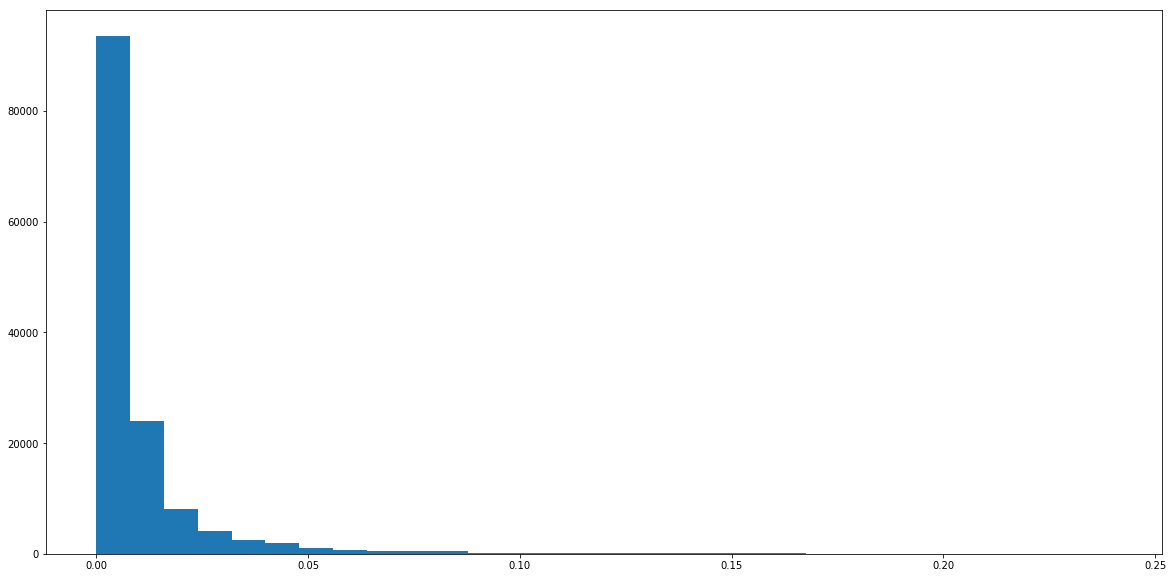

In [45]:
plt.figure(figsize = (20, 10))
plt.hist(pred_calibrated[y_test == 0], bins = 30)

In [46]:
pred_calibrated[y_test == 1].mean()

0.03796061662088431

(array([371., 259., 161., 112.,  97.,  85.,  57.,  45.,  35.,  45.,  50.,
         20.,  23.,  13.,  13.,  14.,   8.,  21.,  15.,  16.,  12.,   7.,
          2.,   5.,   2.,   4.,   1.,   1.,   5.,   1.]),
 array([0.0003291 , 0.0079857 , 0.0156423 , 0.0232989 , 0.03095551,
        0.03861211, 0.04626871, 0.05392531, 0.06158192, 0.06923852,
        0.07689512, 0.08455172, 0.09220833, 0.09986493, 0.10752153,
        0.11517813, 0.12283474, 0.13049134, 0.13814794, 0.14580454,
        0.15346115, 0.16111775, 0.16877435, 0.17643095, 0.18408756,
        0.19174416, 0.19940076, 0.20705736, 0.21471397, 0.22237057,
        0.23002717]),
 <a list of 30 Patch objects>)

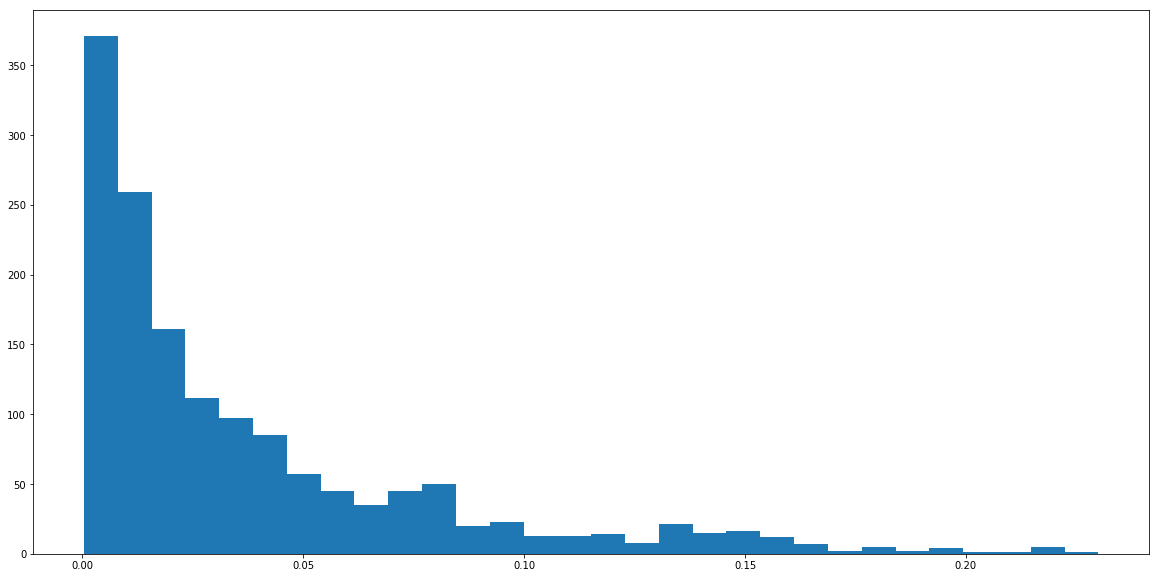

In [47]:
plt.figure(figsize = (20, 10))
plt.hist(pred_calibrated[y_test == 1], bins = 30)

(array([1.06715e+05, 1.88930e+04, 5.46600e+03, 3.06700e+03, 1.38700e+03,
        8.87000e+02, 7.61000e+02, 4.10000e+02, 2.36000e+02, 1.66000e+02,
        1.25000e+02, 1.15000e+02, 1.22000e+02, 7.50000e+01, 3.40000e+01,
        1.50000e+01, 1.20000e+01, 7.00000e+00, 4.00000e+00, 3.00000e+00]),
 array([0.        , 0.01197755, 0.0239551 , 0.03593265, 0.0479102 ,
        0.05988775, 0.07186529, 0.08384284, 0.09582039, 0.10779794,
        0.11977549, 0.13175304, 0.14373059, 0.15570814, 0.16768569,
        0.17966324, 0.19164078, 0.20361833, 0.21559588, 0.22757343,
        0.23955098]),
 <a list of 20 Patch objects>)

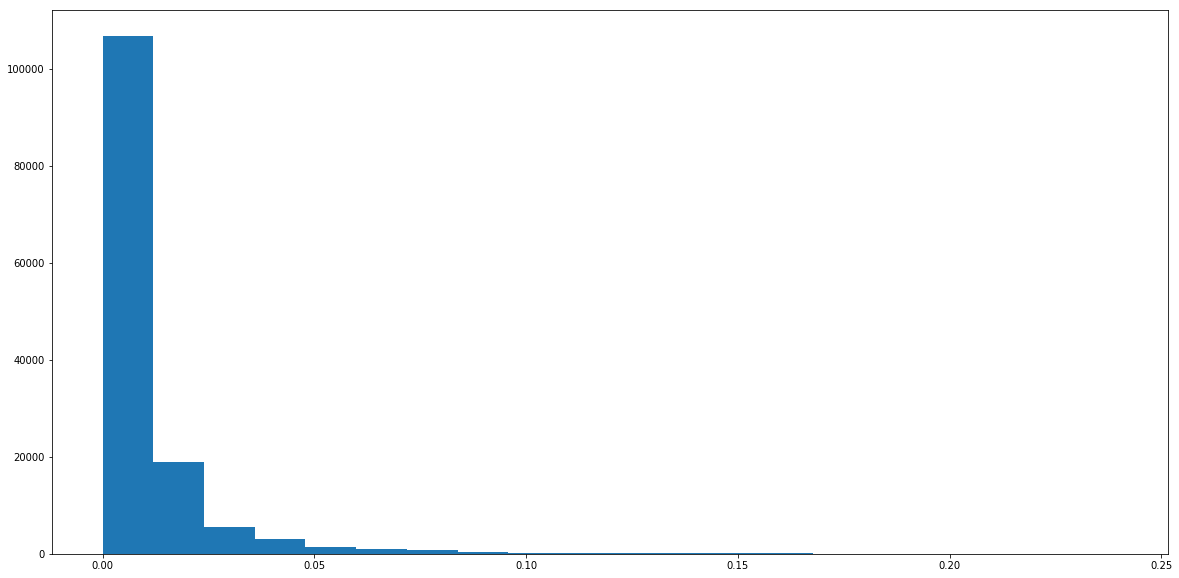

In [48]:
plt.figure(figsize = (20, 10))
plt.hist(pred_calibrated[y_test == 0], bins = 20)

In [49]:
pred_calibrated[pred_calibrated > 0.06].mean()

0.09308989564591061

In [50]:
fsc = list()
best_prob = 0
max_f = 0
prob = 0
while prob < 0.7:
    prob += 0.01
    lgb_pred2 = pd.Series(pred_calibrated)
    lgb_pred2 = lgb_pred2.apply(lambda x: 1 if x >= prob else 0)
    fsc.append(f1_score(y_test, lgb_pred2))
    if f1_score(y_test, lgb_pred2) > max_f:
        best_prob = prob
        max_f = f1_score(y_test, lgb_pred2) 

C:\Users\DFursov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [51]:
print(best_prob)

0.07


In [52]:
imp = pd.Series(lgb_model.feature_importances_, index = train_columns)

In [53]:
imp.sort_values(ascending = False).to_csv('importances_tar_hairmask_14d.csv', index = True, sep = ';')